<a href="https://colab.research.google.com/github/PongsakornChuneyoo/hello-world/blob/master/test6%E0%B9%80%E0%B8%89%E0%B8%9E%E0%B8%B2%E0%B8%B030KPH%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_%E0%B8%AA%E0%B8%A3%E0%B9%89%E0%B8%B2%E0%B8%87_%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5_AI_%E0%B8%88%E0%B8%B2%E0%B8%81_voc_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PASCAL-VOC Detection model Training

refer ; https://github.com/AIWintermuteAI/aXeleRate?fbclid=IwAR0qOevlKD1pVGtVhbGZqUiQmCTFArqEYaepNMsJnaptNUmBhU_Dr-UJfFg

update 22/12/64

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


เริ่มต้นด้วยโหลดไลบรารี่ต่างที่เกี่ยววข้อง

In [2]:
!pip uninstall -y imgaug && pip uninstall -y albumentations && pip install imgaug==0.4
!git clone -b legacy-yolov2 https://github.com/AIWintermuteAI/aXeleRate.git
import sys
sys.path.append('/content/aXeleRate')
from axelerate import setup_training, setup_inference

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Found existing installation: albumentations 1.2.1
Uninstalling albumentations-1.2.1:
  Successfully uninstalled albumentations-1.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 2.1 MB/s 
Cloning into 'aXeleRate'...
remote: Enumerating objects: 2404, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 2404 (delta 201), reused 178 (delta 176), pack-reused 2179
Receiving objects: 100% (2404/2404), 9.66 MiB | 10.06 MiB/s, done.
Resolving deltas: 100% (1577/1577), done.


โหลดไฟล์ จากไดร์
- ตัวอย่างแยกหมา กับ แมว : 
      1pZOfpsMyxqz1e6PS4TIyp9uW922791HF
      14A0COuMAprA-sMRz_FftuijWLxsjLVwO





In [3]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=12ouhw_LRWehre990ueRb8GlrTn9147p4  #pascal-voc dataset 

!unzip --qq JPEGImages.zip # unzip ไฟล์ ในไฟล์ตัวอย่างจะชื่อ cat_dog.zip ซึ่งเป็นไฟที่ได้โหลดมาจากไดร์

Downloading...
From: https://drive.google.com/uc?id=12ouhw_LRWehre990ueRb8GlrTn9147p4
To: /content/JPEGImages.zip
100% 6.09M/6.09M [00:00<00:00, 62.0MB/s]


In [4]:
%matplotlib inline
!gdown https://drive.google.com/uc?id=1UlRnp0I0ZPYlTlfUrt5DsgWwNKvDOfaB  #pascal-voc dataset 

!unzip --qq Annotations.zip # unzip ไฟล์ ในไฟล์ตัวอย่างจะชื่อ cat_dog.zip ซึ่งเป็นไฟที่ได้โหลดมาจากไดร์

Downloading...
From: https://drive.google.com/uc?id=1UlRnp0I0ZPYlTlfUrt5DsgWwNKvDOfaB
To: /content/Annotations.zip
100% 228k/228k [00:00<00:00, 113MB/s]


นำไฟล์ที่โหลดมา แสดงเป็นตัวอย่าง
- ในตำแหน่ง img_folder='/content/JPEGImages' ต้องแก้ไข JPEGImages ให้ตรงกับชื่อไฟล์ที่เก็บรูป
- ในตำแหน่ง ann_folder='/content/Annotations' ต้องแก้ไข Annotations ให้ตรงกับชื่อไฟล์ที่เก็บ Data 

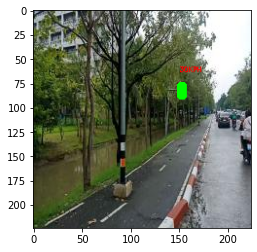

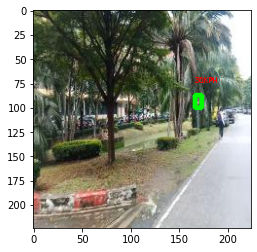

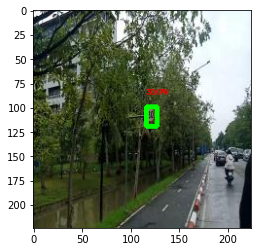

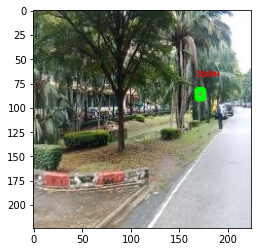

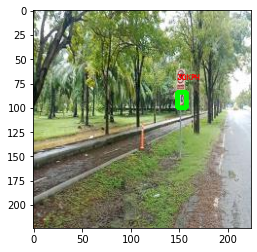

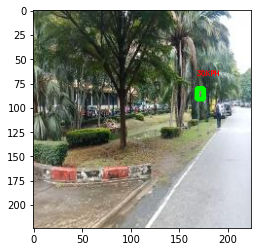

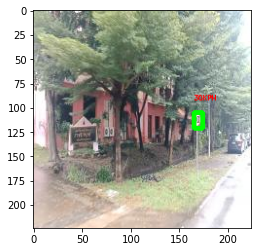

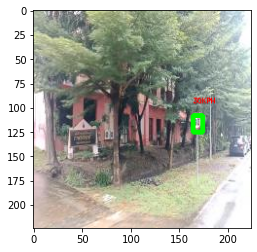

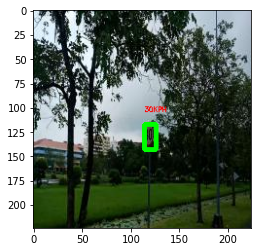

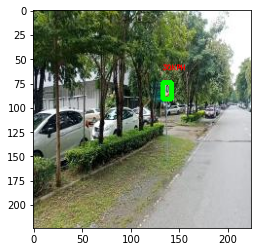

In [5]:
from axelerate.networks.common_utils.augment import visualize_detection_dataset
visualize_detection_dataset(img_folder='/content/JPEGImages', ann_folder='/content/Annotations', num_imgs=10, img_size=224, augment=False)

In [6]:
import os
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

สร้าง โฟร์เดอร์ ขึ้นมาใหม่เพื่อ ใช้สำหรับเก็บรูปและData สำหรับ test 


In [7]:
createFolder('/content/annotations_v/')
createFolder('/content/images_v/')

คัดรูป และ Data ไปใส่ที่โฟร์เดอร์ที่สร้างขึ้นใหม่ ใช้สำหรับ test

ส่วนใหญ่แล้วจะใช้รูปสำหรับ test ที่ 30% 
- ในบรรทัด files = files[0:90] ตัวเลข 90 คือจำนวนที่ต้องการแยกออกมา

ตัวอย่างเช่น มีรูปทั้งหมด 500 รูป 30% จะได้ 150
- จะได้ files = files[0:150]

ตำแหน่ง 
- imgSrc ที่อยู่โฟร์เดอร์รูป ทั้งหมด
- imgTarget ที่อยู่โฟร์เดอร์รูป ที่คัดออกมา ใช้สำหรับ test
- annoSrc ที่อยู่โฟร์เดอร์ Data ทั้งหมด
-  annoTarget ที่อยู่โฟร์เดอร์ Data ที่คัดออกมา ใช้สำหรับ test

In [8]:
import os, random, shutil
files = os.listdir("/content/JPEGImages/")
random.shuffle(files)
files = files[0:127]
for file in files:
    imgSrc = "/content/JPEGImages/" + file
    imgTarget = "/content/images_v/" + file
    annoSrc = "/content/Annotations/" + os.path.splitext(file)[0] + ".xml"
    annoTarget = "/content/annotations_v/" + os.path.splitext(file)[0] + ".xml"
    shutil.move(imgSrc,imgTarget)
    shutil.move(annoSrc,annoTarget)

Type is model frontend - Classifier, Detector or Segnet

Architecture is model backend (feature extractor) 

- MobileNet1_0
- MobileNet7_5 
- MobileNet5_0 
- MobileNet2_5 

ในตำแหน่ง labels ใน ["dog", "cat"] สามารถแก้ใขให้ตรงกับ dataset ที่ทำมาก่อนหน้า

ในตำแหน่ง actual_epoch คือจำนวนรอบในการ train

train_image_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์รูปสำหรับ train

train_annot_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์ Data สำหรับ train

valid_image_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์รูปสำหรับ test

valid_annot_folder ใส่ตำแหน่งที่อยู่โฟร์เดอร์ Data สำหรับ train



In [9]:
config = {
        "model":{
            "type":                 "Detector",
            "architecture":         "MobileNet7_5",
            "input_size":           224,
            "anchors":              [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828],
            "labels":               ["30KPH"],
            "coord_scale" : 		1.0,
            "class_scale" : 		1.0,
            "object_scale" : 		5.0,
            "no_object_scale" : 	1.0
        },
        "weights" : {
            "full":   				"",
            "backend":   		    "imagenet"
        },
        "train" : {
            "actual_epoch":         1000,
            "train_image_folder":   "/content/JPEGImages",
            "train_annot_folder":   "/content/Annotations",
            "train_times":          1,
            "valid_image_folder":   "/content/images_v",
            "valid_annot_folder":   "/content/annotations_v",
            "valid_times":          1,
            "valid_metric":         "mAP",
            "batch_size":            32,
            "learning_rate":        0.0004,
            "saved_folder":   		"/content/MODEL",
            "first_trainable_layer": "",
            "augumentation":				False,
            "is_only_detect" : 		False
        },
        "converter" : {
            "type":   				["k210"]
        }
    }

In [10]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 608042794292944243
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2186238127857997536
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [11]:
from keras import backend as K 
K.clear_session()
model_path = setup_training(config_dict=config)

Project folder /content/MODEL is created.
7528448/7513544 [==============================] - 0s 0us/step
/content/aXeleRate/axelerate/networks/common_utils/ncc_linux_x86_64.tar.xz
['30KPH']
10641408/10626956 [==============================] - 0s 0us/step
Successfully loaded imagenet backend weights
Failed to load pre-trained weights for the whole model. It might be because you didn't specify any or the weight file cannot be found
Current training session folder is /content/MODEL/2022-09-21_05-09-55


Model: "yolo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 conv_pw_8 (Conv2D)          (None, 14, 14, 384)       147456    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 14, 14, 384)      1536      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 14, 14, 384)       0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 14, 14, 384)      3456      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 14, 14, 384)      1536      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 14, 14, 384)       0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 14, 14, 384)       147456    
          

/content/aXeleRate/axelerate/networks/common_utils/fit.py:129: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  use_multiprocessing = True)


Epoch 1/1000
9/9 [==============================] - ETA: 0s - loss: 0.2824

/content/aXeleRate/axelerate/networks/yolo/backend/batch_gen.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return imgs_list, np.array(anns_list)


เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
mAP did not improve from 0.7273685552172979.
Epoch 00444: Learning rate is 0.0002354879298214702.

9/9 [==============================] - 11s 1s/step - loss: 0.0044 - val_loss: 0.0174
Epoch 446/1000
9/9 [==============================] - ETA: 0s - loss: 0.0040

30KPH 0.4558
mAP: 0.4558
mAP did not improve from 0.7273685552172979.
Epoch 00445: Learning rate is 0.00023486754586659467.

9/9 [==============================] - 12s 1s/step - loss: 0.0040 - val_loss: 0.0200
Epoch 447/1000
9/9 [==============================] - ETA: 0s - loss: 0.0044

30KPH 0.4189
mAP: 0.4189
mAP did not improve from 0.7273685552172979.
Epoch 00446: Learning rate is 0.00023424681570901945.

9/9 [==============================] - 12s 1s/step - loss: 0.0044 - val_loss: 0.0196
Epoch 448/1000
9/9 [==============================] - ETA: 0s - loss: 0.0033

30KPH 0.4265
mAP: 0.4265
mAP did not improve from 0.7273685552172979.
Epoch 00447: Learning rate is 0.000

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


Converting to tflite without Reshape
/content/MODEL/2022-09-21_05-09-55/YOLO_best_mAP.kmodel
/content/aXeleRate/axelerate/networks/common_utils/ncc/ncc compile "/content/MODEL/2022-09-21_05-09-55/YOLO_best_mAP.tflite" "/content/MODEL/2022-09-21_05-09-55/YOLO_best_mAP.kmodel" -i tflite --weights-quantize-threshold 1000 --dataset-format raw --dataset "/content/aXeleRate/axelerate/networks/common_utils/tmp"
1. Import graph...

2. Optimize Pass 1...

3. Optimize Pass 2...

4. Quantize...

  4.1. Add quantization checkpoints...

  4.2. Get activation ranges...

  Plan buffers...

  Run calibration...

  [>                                                 ] 0% 0s

  [>                                                 ] 0% 0.7s

  [>                                                 ] 1% 1.398s

  [=>                                                ] 2% 2.099s

  [=>                                                ] 3% 2.794s

  [=>                                                ] 3% 3.49s

  [==> 